<a href="https://colab.research.google.com/github/simecek/dspracticum2021/blob/main/lesson06/Predicting_Wikipedia_Web_Traffic_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import pandas as pd 
import datetime 
import warnings
from google_drive_downloader import GoogleDriveDownloader as gdd

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from fbprophet import Prophet

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import Data From Google Drive

In [2]:
# https://www.kaggle.com/c/web-traffic-time-series-forecasting
# NaN changed to zero, test dataset reshaped

gdd.download_file_from_google_drive("1hoRCIko7XD73WDVSMCNJUYMSjWwQaeKr", "./test.pkl")
gdd.download_file_from_google_drive("1-1HQVh-nVfNj1to2DW2Rpyfv5xFQqlpa", "./train.pkl")

In [3]:
!ls -hl

total 975M
drwxr-xr-x 1 root root 4.0K Oct  8 13:45 sample_data
-rw-r--r-- 1 root root  78M Oct 23 08:00 test.pkl
-rw-r--r-- 1 root root 898M Oct 23 08:00 train.pkl


In [4]:
train = pd.read_pickle("train.pkl")
test = pd.read_pickle("test.pkl")

In [5]:
train

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
Page,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
!vote_en.wikipedia.org_all-access_all-agents,3.0,4.0,7.0,4.0,4.0,2.0,3.0,7.0,2.0,0.0,3.0,1.0,2.0,2.0,3.0,2.0,1.0,1.0,1.0,0.0,6.0,8.0,5.0,1.0,2.0,1.0,2.0,10.0,4.0,6.0,4.0,2.0,1.0,4.0,1.0,2.0,0.0,0.0,1.0,0.0,...,11.0,8.0,7.0,13.0,8.0,15.0,11.0,11.0,19.0,19.0,14.0,13.0,14.0,8.0,12.0,11.0,9.0,8.0,5.0,16.0,6.0,23.0,12.0,16.0,8.0,19.0,18.0,6.0,11.0,15.0,16.0,12.0,10.0,7.0,11.0,8.0,5.0,15.0,6.0,9.0
!vote_en.wikipedia.org_all-access_spider,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4.0,1.0,0.0,1.0,0.0,2.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,9.0,3.0,0.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,11.0,5.0,6.0,5.0,9.0,7.0,2.0,0.0,2.0,0.0,1.0,3.0,1.0,0.0,2.0,2.0,2.0,2.0,0.0
!vote_en.wikipedia.org_desktop_all-agents,3.0,4.0,7.0,4.0,4.0,2.0,3.0,7.0,2.0,0.0,3.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,1.0,0.0,5.0,8.0,4.0,1.0,1.0,1.0,2.0,10.0,3.0,6.0,3.0,2.0,1.0,4.0,0.0,2.0,0.0,0.0,1.0,0.0,...,6.0,7.0,1.0,5.0,2.0,4.0,3.0,6.0,12.0,13.0,6.0,5.0,6.0,4.0,5.0,4.0,3.0,4.0,0.0,5.0,3.0,16.0,7.0,12.0,6.0,12.0,12.0,4.0,1.0,4.0,8.0,6.0,4.0,5.0,4.0,2.0,2.0,9.0,3.0,3.0
"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1659.0,1518.0,1685.0,1448.0,1668.0,1737.0,1609.0,1812.0,1569.0,1508.0,1417.0,1463.0,1473.0,1426.0,1364.0,1337.0,1355.0,1241.0,1356.0,1289.0,1258.0,1268.0,1208.0,1184.0,1045.0,1127.0,1102.0,1192.0,1155.0,1093.0,1090.0,1090.0,1100.0,1164.0,1047.0,1144.0,1092.0,1065.0,978.0,972.0
"""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,14.0,16.0,14.0,17.0,22.0,15.0,16.0,14.0,24.0,14.0,16.0,36.0,20.0,26.0,12.0,14.0,9.0,17.0,10.0,14.0,24.0,25.0,36.0,12.0,28.0,37.0,29.0,31.0,12.0,30.0,30.0,29.0,34.0,24.0,14.0,18.0,30.0,20.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
대문_commons.wikimedia.org_desktop_all-agents,154.0,182.0,168.0,153.0,92.0,157.0,224.0,155.0,128.0,187.0,109.0,135.0,147.0,184.0,174.0,149.0,143.0,189.0,138.0,186.0,188.0,150.0,175.0,126.0,155.0,135.0,184.0,163.0,140.0,129.0,148.0,100.0,104.0,145.0,188.0,188.0,202.0,161.0,113.0,125.0,...,152.0,166.0,161.0,136.0,89.0,146.0,134.0,140.0,149.0,171.0,132.0,203.0,138.0,246.0,162.0,196.0,174.0,117.0,130.0,215.0,185.0,241.0,181.0,179.0,160.0,163.0,232.0,171.0,190.0,116.0,138.0,178.0,155.0,234.0,237.0,1742.0,5803.0,197.0,136.0,190.0
［Alexandros］_ja.wikipedia.org_all-access_all-agents,5438.0,5966.0,5727.0,7036.0,7078.0,5009.0,4559.0,4544.0,4191.0

In [6]:
test.head()

JustDate,2017-09-13,2017-09-14,2017-09-15,2017-09-16,2017-09-17,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-23,2017-09-24,2017-09-25,2017-09-26,2017-09-27,2017-09-28,2017-09-29,2017-09-30,2017-10-01,2017-10-02,2017-10-03,2017-10-04,2017-10-05,2017-10-06,2017-10-07,2017-10-08,2017-10-09,2017-10-10,2017-10-11,2017-10-12,2017-10-13,2017-10-14,2017-10-15,2017-10-16,2017-10-17,2017-10-18,2017-10-19,2017-10-20,2017-10-21,2017-10-22,2017-10-23,2017-10-24,2017-10-25,2017-10-26,2017-10-27,2017-10-28,2017-10-29,2017-10-30,2017-10-31,2017-11-01,2017-11-02,2017-11-03,2017-11-04,2017-11-05,2017-11-06,2017-11-07,2017-11-08,2017-11-09,2017-11-10,2017-11-11,2017-11-12,2017-11-13
JustPage,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
!vote_en.wikipedia.org_all-access_all-agents,9.0,9.0,6.0,13.0,11.0,10.0,13.0,6.0,12.0,15.0,12.0,2.0,7.0,8.0,5.0,3.0,4.0,6.0,7.0,7.0,5.0,4.0,6.0,6.0,5.0,1.0,4.0,3.0,7.0,9.0,5.0,3.0,1.0,5.0,4.0,4.0,4.0,4.0,6.0,8.0,6.0,11.0,4.0,6.0,2.0,6.0,3.0,8.0,8.0,6.0,3.0,5.0,9.0,9.0,6.0,12.0,5.0,4.0,4.0,4.0,5.0,5.0
!vote_en.wikipedia.org_all-access_spider,3.0,1.0,0.0,2.0,0.0,4.0,1.0,1.0,5.0,2.0,9.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,3.0,0.0,2.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,1.0,3.0,1.0,1.0,3.0,2.0,2.0,1.0,3.0,1.0,2.0,2.0,4.0,1.0,1.0,2.0,3.0,1.0,2.0,2.0,1.0,0.0,1.0,1.0,2.0
!vote_en.wikipedia.org_desktop_all-agents,7.0,4.0,3.0,5.0,5.0,6.0,6.0,2.0,8.0,4.0,10.0,2.0,6.0,6.0,3.0,1.0,3.0,2.0,2.0,2.0,3.0,4.0,4.0,3.0,3.0,1.0,3.0,0.0,6.0,8.0,4.0,2.0,0.0,4.0,1.0,1.0,1.0,1.0,3.0,5.0,3.0,7.0,3.0,3.0,1.0,4.0,1.0,3.0,5.0,6.0,1.0,4.0,5.0,4.0,2.0,5.0,3.0,2.0,2.0,2.0,2.0,3.0
"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents",1010.0,997.0,976.0,1019.0,1062.0,3777.0,1955.0,1375.0,1161.0,1084.0,1082.0,1093.0,1147.0,1077.0,1001.0,1055.0,1189.0,1036.0,1055.0,1048.0,1018.0,1076.0,971.0,909.0,945.0,908.0,950.0,957.0,856.0,892.0,832.0,858.0,1033.0,949.0,942.0,886.0,860.0,923.0,819.0,853.0,877.0,858.0,904.0,837.0,767.0,684.0,822.0,809.0,810.0,770.0,1283.0,939.0,787.0,868.0,911.0,903.0,828.0,915.0,882.0,832.0,930.0,873.0
"""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider",21.0,26.0,27.0,17.0,32.0,34.0,26.0,22.0,21.0,15.0,24.0,23.0,42.0,20.0,12.0,24.0,17.0,23.0,23.0,22.0,16.0,24.0,32.0,17.0,16.0,13.0,38.0,25.0,30.0,31.0,30.0,22.0,24.0,19.0,25.0,38.0,26.0,42.0,35.0,18.0,17.0,13.0,19.0,21.0,36.0,17.0,36.0,10.0,12.0,9.0,17.0,9.0,14.0,17.0,10.0,14.0,15.0,17.0,11.0,8.0,10.0,42.0


## Small subset of highly accessed pages

In [7]:
median_visits = train.median(axis = 1)
over100000 = median_visits > 100_000
sum(over100000)

42

In [8]:
train_filtered = train[over100000].apply(np.log1p).copy()
test_filtered = test[over100000].apply(np.log1p).copy()

In [9]:
train_filtered.shape, test_filtered.shape

((42, 803), (42, 62))

## Simple Graph

In [10]:
dropdown_options = list(train_filtered.index.values)
dropdown_options

['Especial:Buscar_es.wikipedia.org_all-access_all-agents',
 'Especial:Buscar_es.wikipedia.org_desktop_all-agents',
 'Main_Page_en.wikipedia.org_all-access_all-agents',
 'Main_Page_en.wikipedia.org_all-access_spider',
 'Main_Page_en.wikipedia.org_desktop_all-agents',
 'Main_Page_en.wikipedia.org_mobile-web_all-agents',
 'Sp?cial:Search_fr.wikipedia.org_all-access_all-agents',
 'Sp?cial:Search_fr.wikipedia.org_desktop_all-agents',
 'Special:Book_en.wikipedia.org_all-access_all-agents',
 'Special:Book_en.wikipedia.org_desktop_all-agents',
 'Special:Search_commons.wikimedia.org_all-access_all-agents',
 'Special:Search_commons.wikimedia.org_desktop_all-agents',
 'Special:Search_en.wikipedia.org_all-access_all-agents',
 'Special:Search_en.wikipedia.org_desktop_all-agents',
 'Special:Search_en.wikipedia.org_mobile-web_all-agents',
 'Spezial:Suche_de.wikipedia.org_all-access_all-agents',
 'Spezial:Suche_de.wikipedia.org_desktop_all-agents',
 'Spécial:Recherche_fr.wikipedia.org_all-access_all-a

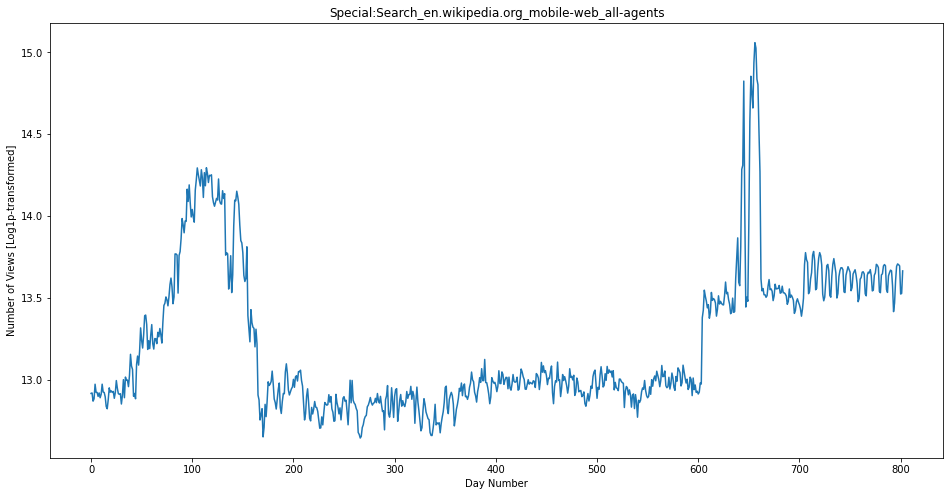

In [11]:
#dropdown_options = list(train_filtered.index.values)
page = 'Special:Search_en.wikipedia.org_mobile-web_all-agents' #@param {type:"string"}
#print(page)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    train_dropdown = train_filtered.loc[page, :]
    days = range(len(train_dropdown))
    plt.figure(figsize=(16,8))
    plt.plot(days, train_dropdown.values)
    plt.ylabel('Number of Views [Log1p-transformed]')
    plt.xlabel('Day Number')
    plt.title(page)
    plt.show()

## Task 1 - Simple Predictions

Take the data frame `train` and create several data frames with forecasts using some simple method like

*   Median
*   Median per day of the week
*   Copy of the last year or week data 

The data frames should have the same size and index as `test`.

In [12]:
# median
medians = train_filtered.median(axis=1)
medians_df = pd.DataFrame({i: medians for i in range(test_filtered.shape[1])})
assert all(medians_df.index.values == test_filtered.index.values)
medians_df.shape

(42, 62)

In [85]:
# DOW

DOW_medians = []

for i in range(7):
  only_selected_days = train_filtered.iloc[:,range(i, train_filtered.shape[1], 7)]
  DOW_medians.append(only_selected_days.median(axis=1))

DOW_medians_df = pd.DataFrame({i: DOW_medians[(i + train_filtered.shape[1] + 2) % 7] for i in range(test_filtered.shape[1])})
DOW_medians_df.shape

(42, 62)

In [86]:
# last week repeated forever

last_week = train_filtered.iloc[:, -7:]
last_week_df = pd.DataFrame({i: last_week.iloc[:,(i+2)%7] for i in range(test_filtered.shape[1])})
last_week_df.shape

(42, 62)

## Task 2 - Calculate average SMAPE

Look at https://www.kaggle.com/c/web-traffic-time-series-forecasting/overview/evaluation for a definition of SMAPE. Write a function that given two data frames (one with forecasts and one with actual values), calculate the average SMAPE. Test it on forecasts from Task 1.

In [87]:
def SMAPE(logA, logF):
  A = np.expm1(logA.values)
  F = np.expm1(logF.values)
  smape = 200 * (np.abs(A-F) / (np.abs(A) + np.abs(F)))
  return smape.mean()

SMAPE(test_filtered, medians_df), SMAPE(test_filtered, DOW_medians_df), SMAPE(test_filtered, last_week_df)

(36.484445973566324, 34.96887676648697, 16.47307953729954)

## Task 3 - Visualization of forecasts

Write a function that given a time series id, plot its training values, forecasts and actual values into one plot. (Optional: can you fit several forecasts into one plot?)

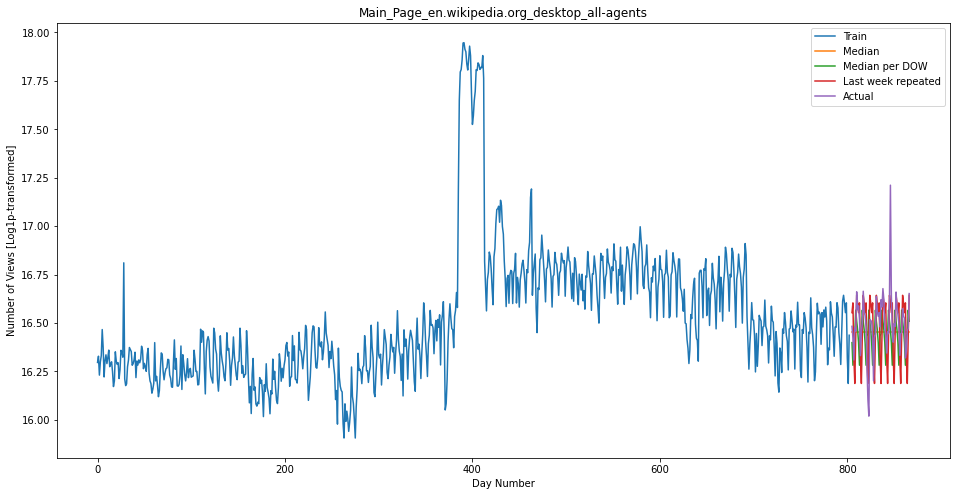

In [35]:
#page = 'Special:Search_en.wikipedia.org_mobile-web_all-agents' #@param {type:"string"}
#page = 'Especial:Buscar_es.wikipedia.org_all-access_all-agents'
#page = 'XHamster_en.wikipedia.org_all-access_all-agents'
page = 'Main_Page_en.wikipedia.org_desktop_all-agents'

forecasts = [(medians_df, "Median"), 
             (DOW_medians_df, "Median per DOW"),
             (last_week_df, "Last week repeated")]    

def create_plot(page, train_df, test_df, forecast_list, figsize=(16,8)):
    train_plot = train_df.loc[page, :].values
    test_plot = test_df.loc[page, :].values
    days_train = list(range(len(train_plot)))
    days_test  = list(range(len(train_plot)+2, len(train_plot)+2+len(test_plot)))

    plt.figure(figsize=figsize)
    plt.plot(days_train, train_plot, label = "Train")
    for f in forecast_list:
        plt.plot(days_test, f[0].loc[page, :].values, label = f[1])
    plt.plot(days_test, test_plot, label = "Actual")
    plt.ylabel('Number of Views [Log1p-transformed]')
    plt.xlabel('Day Number')
    plt.title(page)
    plt.legend()
    plt.show()

create_plot(page, train_filtered, test_filtered, forecasts)

In [62]:
import plotly.express as px

def create_plotly(page, train_df, test_df, forecast_list, figsize=(16,8)):
    train_plot = train_df.loc[page, :].values
    test_plot = test_df.loc[page, :].values
    days_train = list(range(len(train_plot)))
    days_test  = list(range(len(train_plot)+2, len(train_plot)+2+len(test_plot)))

    labels = [[f[1]]*len(test_plot) for f in forecast_list]
    flat_labels = [item for sublist in labels for item in sublist]
    df_plot = pd.DataFrame({
        'Day Number': days_train + days_test + days_test * len(forecast_list),
        'Number of Views [Log1p-transformed]': np.concatenate([train_plot, test_plot] + [f[0].loc[page, :].values for f in forecast_list]),
        'TS': ['Train'] * len(train_plot) + ['Actual'] * len(test_plot) + flat_labels,
    })

    fig = px.line(df_plot, x='Day Number', y='Number of Views [Log1p-transformed]', 
                  color='TS')
    fig.show()

create_plotly(page, train_filtered, test_filtered, forecasts)

## Task 4 - STL Decomposition

Decompose each time series with `seasonal_decompose` into a trend, annual seasonality, weekly seasonality and the remainder. Try to make a simple forecast on the decomposed componens of the time series.

array([ 0.02153974, -0.03085467, -0.12681786, -0.02720485,  0.00094325,
        0.11555687,  0.04683752])

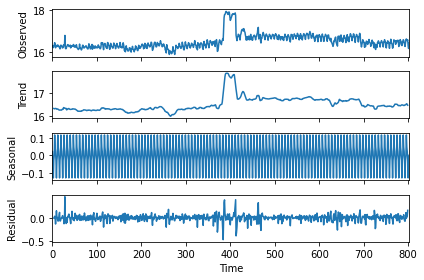

In [79]:
ts = train_filtered.loc[page,:].values

seasonality_week = seasonal_decompose(ts, freq=7, model='additive')
seasonality_week.plot();

ts_adjusted = ts - seasonality_week.seasonal
seasonality_week.seasonal[:7]

In [88]:
def DOW_decomposition(ts):
    seasonality_week = seasonal_decompose(ts, freq=7, model='additive')
    return seasonality_week.seasonal

DOW_component = train_filtered.apply(DOW_decomposition, axis=1)
DOW_component_test = pd.DataFrame({i: DOW_component.iloc[:,(train_filtered.shape[1]+2+i)%7] for i in range(test_filtered.shape[1])})
DOW_component.shape, DOW_component_test.shape

((42, 803), (42, 62))

In [109]:
def annual_decomposition(ts):
    seasonality_year = seasonal_decompose(ts, freq=365, model='additive')
    return seasonality_year.seasonal

Annual_component = (train_filtered - DOW_component).apply(annual_decomposition, axis=1)
Annual_component_test = pd.DataFrame({i: Annual_component.iloc[:,(train_filtered.shape[1]+2+i)%365] for i in range(test_filtered.shape[1])})
Annual_component.shape, Annual_component_test.shape

((42, 803), (42, 62))

In [110]:
train_adjusted = train_filtered - DOW_component - Annual_component
test_adjusted = test_filtered - DOW_component_test.values - Annual_component_test.values
train_adjusted.shape, test_adjusted.shape

((42, 803), (42, 62))

## Task 5 - Exponential Smoothing, ARIMA

Try to use more advanced methods on the decomposed dataset like exponential smoothing or ARIMA.

#### Exponential Smoothing

In [105]:
ts = train_adjusted.loc[page,:].values

Holt(ts).fit().forecast(test_filtered.shape[1]+2)

array([16.3730215 , 16.37305464, 16.37308778, 16.37312092, 16.37315406,
       16.37318721, 16.37322035, 16.37325349, 16.37328663, 16.37331977,
       16.37335291, 16.37338605, 16.37341919, 16.37345233, 16.37348547,
       16.37351861, 16.37355175, 16.37358489, 16.37361803, 16.37365117,
       16.37368431, 16.37371746, 16.3737506 , 16.37378374, 16.37381688,
       16.37385002, 16.37388316, 16.3739163 , 16.37394944, 16.37398258,
       16.37401572, 16.37404886, 16.374082  , 16.37411514, 16.37414828,
       16.37418142, 16.37421456, 16.37424771, 16.37428085, 16.37431399,
       16.37434713, 16.37438027, 16.37441341, 16.37444655, 16.37447969,
       16.37451283, 16.37454597, 16.37457911, 16.37461225, 16.37464539,
       16.37467853, 16.37471167, 16.37474481, 16.37477796, 16.3748111 ,
       16.37484424, 16.37487738, 16.37491052, 16.37494366, 16.3749768 ,
       16.37500994, 16.37504308, 16.37507622, 16.37510936])

In [111]:
def forecast_Holt(ts, nsteps=test_filtered.shape[1]+2, remove_first_ksteps=2):
  return Holt(ts).fit().forecast(nsteps)[remove_first_ksteps:]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Holt_adjusted = train_adjusted.apply(forecast_Holt, axis=1)

print(Holt_adjusted.shape)
SMAPE(test_filtered, Holt_adjusted + DOW_component_test.values + Annual_component_test.values)

(42, 62)


23.01274544057856

In [112]:
def forecast_SimpleExpSmoothing(ts, nsteps=test_filtered.shape[1]+2, remove_first_ksteps=2):
  return SimpleExpSmoothing(ts).fit().forecast(nsteps)[remove_first_ksteps:]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    SimpleExpSmoothing_adjusted = train_adjusted.apply(forecast_SimpleExpSmoothing, axis=1)

print(SimpleExpSmoothing_adjusted.shape)
SMAPE(test_filtered, SimpleExpSmoothing_adjusted + DOW_component_test.values + Annual_component_test.values)

(42, 62)


20.805785883839174

#### ARIMA

In [133]:
from statsmodels.tsa.arima_model import ARIMA


ts = train_adjusted.loc[page,:].values
model = ARIMA(ts, order=(2, 1, 2))
fitted = model.fit()

fitted.forecast(test_filtered.shape[1]+2)[0][2:]

array([16.3731586 , 16.38139767, 16.41352928, 16.41137955, 16.37963536,
       16.37601039, 16.40643117, 16.41556613, 16.38754867, 16.37357231,
       16.39846589, 16.41671221, 16.395756  , 16.3741596 , 16.39076403,
       16.41494919, 16.40317622, 16.37744701, 16.38432311, 16.41077658,
       16.40892527, 16.38278533, 16.37988902, 16.40496474, 16.41241436,
       16.38931443, 16.37788066, 16.39843066, 16.41340098, 16.39609385,
       16.37836384, 16.39210552, 16.41199038, 16.40223259, 16.38107348,
       16.38681194, 16.40859139, 16.40700105, 16.38547712, 16.38316613,
       16.40383664, 16.40991211, 16.39086775, 16.38151548, 16.39848043,
       16.41076356, 16.39647128, 16.38191669, 16.39328972, 16.40963961,
       16.4015534 , 16.38415378, 16.38894287, 16.40687486, 16.40551198,
       16.38779005, 16.38594894, 16.40298885, 16.40794404, 16.39224435,
       16.384596  , 16.39860204])

In [136]:
def forecast_ARIMA(ts, order=(2,1,1), nsteps=test_filtered.shape[1]+2, remove_first_ksteps=2):
    model = ARIMA(ts, order=order) 
    return pd.Series(model.fit().forecast(nsteps)[0][remove_first_ksteps:])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ARIMA_adjusted = train_adjusted.apply(forecast_ARIMA, axis=1)

print(ARIMA_adjusted.shape)
SMAPE(test_filtered, ARIMA_adjusted + DOW_component_test.values + Annual_component_test.values)

(42, 62)


21.495381343879735

In [145]:
forecasts2 = [(ARIMA_adjusted + DOW_component_test.values + Annual_component_test.values, "ARIMA"),
              (SimpleExpSmoothing_adjusted + DOW_component_test.values + Annual_component_test.values, "SimpleExpSmoothing"),
              (Holt_adjusted + DOW_component_test.values + Annual_component_test.values, "Holt")]

create_plotly(page, train, test, forecasts2)
# message: seasonal decomposition often matters more than the forecasting method

## Task 6 - Prophet

Try to apply Prophet method on the original data (before decomposition).

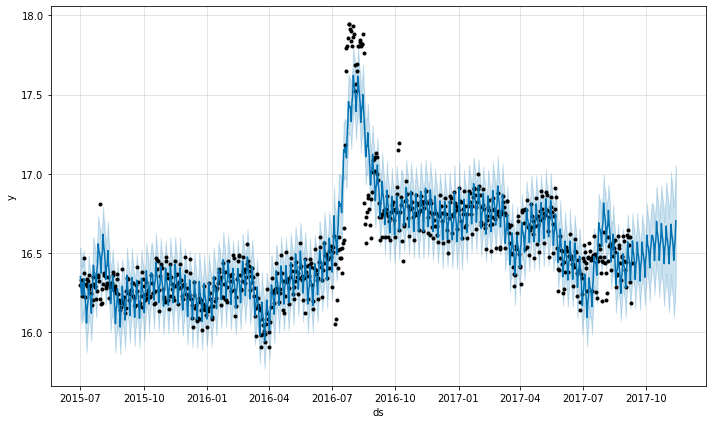

In [168]:
ts = train_filtered.loc[page,:].values

df = pd.DataFrame({ 'ds': train_filtered.T.index.values, 'y': ts})
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
m.add_country_holidays(country_name='US')

m.fit(df)

future = m.make_future_dataframe(periods=test_filtered.shape[1]+2)
forecast = m.predict(future)
m.plot(forecast);

In [171]:
def forecast_Prophet(ts, nsteps=test_filtered.shape[1]+2, remove_first_ksteps=2):
    df = pd.DataFrame({ 'ds': train_filtered.T.index.values, 'y': ts})
    m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
    m.add_country_holidays(country_name='US')

    m.fit(df)

    future = m.make_future_dataframe(periods=nsteps)
    forecast = m.predict(future)
    return forecast['yhat'][-(nsteps-remove_first_ksteps):]

Prophet_df = train_filtered.apply(forecast_Prophet, axis=1)
print(Prophet_df.shape)
SMAPE(test_filtered, Prophet_df)

(42, 62)


28.311952809276775

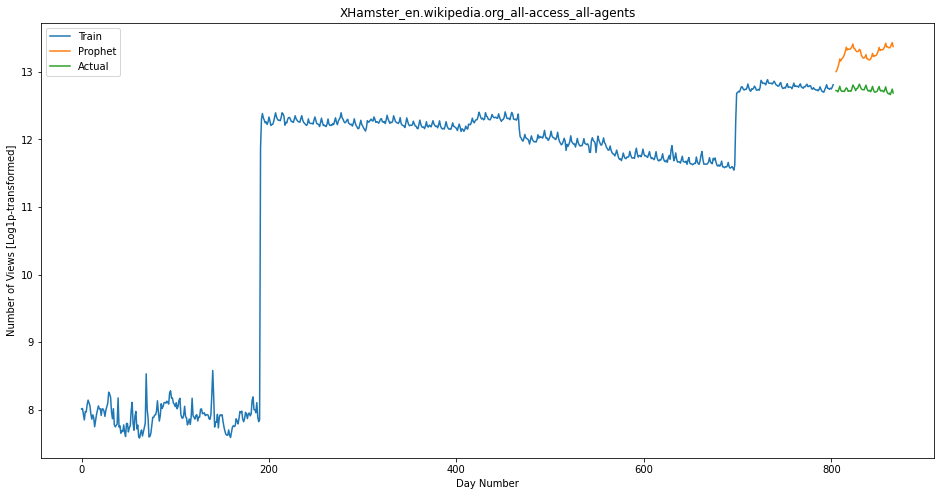

In [175]:
page = 'XHamster_en.wikipedia.org_all-access_all-agents'

create_plot(page, train_filtered, test_filtered, [(Prophet_df, "Prophet")])